In [1]:
# HIDE CODE


# generic imports
import re
import os
import sys
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
import nibabel as nib
from pprint import pprint
from scipy import signal
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from os.path import join as pjoin
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches
from matplotlib import cm
import seaborn as sns
sns.set_style('white')


# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# nx imports
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.classes.function import density

# Louvain etc
import community as community_louvain
from cdlib import algorithms

# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.smallworld import sigma, omega

# Dirs
base_dir = pjoin(os.environ['HOME'], 'Documents/data')
raw_dir = pjoin(base_dir, 'raw')
processed_dir = pjoin(base_dir, 'processed')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import ProcessConfig


# fix random stete
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
rng = np.random.RandomState(RANDOM_STATE)

## Load Original LFR

In [2]:
lfr_ws = 'Documents/workspaces/lfr/weighted_overlapping/networks'
lfr_ws = pjoin(os.environ['HOME'], lfr_ws)
network_name = '001'

load_dir = pjoin(lfr_ws, network_name)
os.listdir(load_dir)

['community.dat', 'statistics.dat', 'network.dat']

In [3]:
g = nx.read_weighted_edgelist(pjoin(load_dir, 'network.dat'), nodetype=int)
g = nx.relabel_nodes(
    G=g,
    mapping={i: i - 1 for i in range(1, g.order() + 1)},
    copy=True,
)

a = nx.adjacency_matrix(g).toarray()
a /= np.max(a)

In [33]:
with open(pjoin(load_dir, 'community.dat'), 'r') as f:
    lines = f.readlines()

membership = dict()
for line in lines:
    node, mem = line.strip('\n').split('\t')
    node = int(node) - 1
    membership[node] = list(int(x) - 1 for x in filter(None, mem.split(' ')))

community = convert('membership', 'community', membership=membership, random_state=rng)
partition = convert('membership', 'partition', membership=membership, random_state=rng)

len(community), len(membership), len(partition)

(6, 1000, 1000)

In [34]:
comm_indxs = []
for x in community.values():
    y = [item for item in x if item not in comm_indxs]
    comm_indxs.extend(y)

len(comm_indxs)

1000

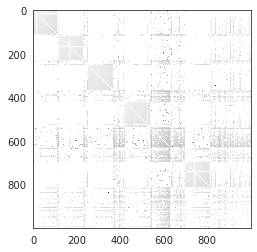

In [36]:
plt.figure(figsize=(6, 4))
plt.imshow(a, cmap='Greys', interpolation='none')

<AxesSubplot:ylabel='Count'>

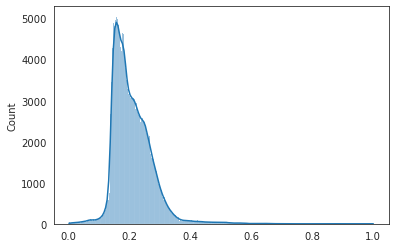

In [38]:
data = a.copy()
data = data[data>0]

sns.histplot(data, kde=True)

In [39]:
num_overlap_nodes = len(list(filter(lambda x: len(x) > 1, membership.values())))
num_overlap_nodes

100

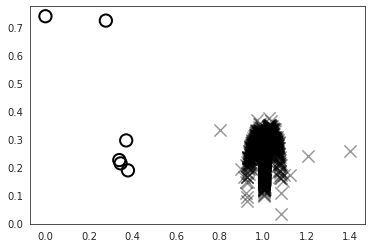

In [40]:
w, v = np.linalg.eigh(nx.normalized_laplacian_matrix(g).toarray())
ipr = 1 / np.power(v, 4).sum(0)
ipr /= len(ipr)
sort_indxs = np.argsort(w)

num_comm = len(community)
plt.scatter(
    w[sort_indxs[num_comm:]], ipr[sort_indxs[num_comm:]],
    marker='x', color='k', s=150, alpha=0.4,
)
plt.scatter(
    w[sort_indxs[:num_comm]], ipr[sort_indxs[:num_comm]],
    marker='o', edgecolors='k', lw=2, color='none', s=150,
)

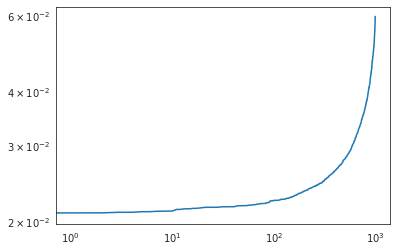

In [41]:
leading_eigenvec = v[:, sort_indxs[0]]
assert all(leading_eigenvec < 0) or all(leading_eigenvec > 0)

plt.loglog(sorted(np.abs(leading_eigenvec)))

In [42]:
partition_louvain = community_louvain.best_partition(g, resolution=1.0, random_state=RANDOM_STATE)

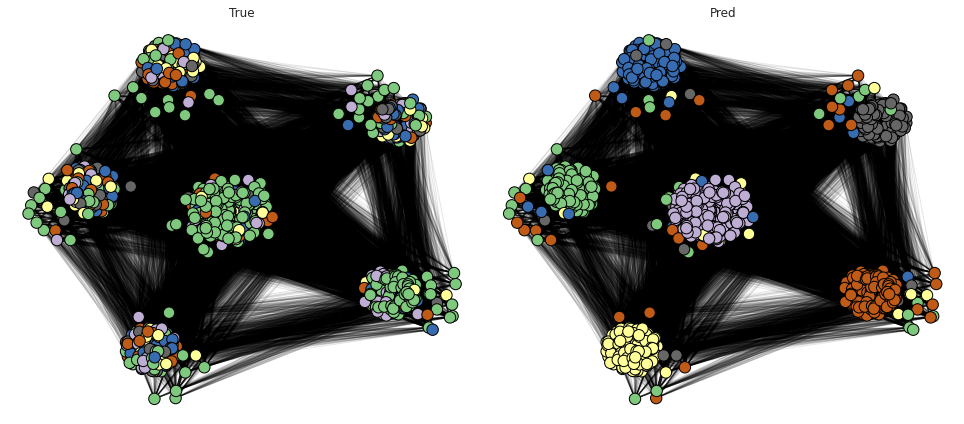

In [43]:
plot_graph(g, partition_pred=partition_louvain, partition_true=partition)

## LFR Original (no overlap)

In [44]:
lfr_ws = 'Documents/workspaces/lfr/weighted_overlapping/networks'
lfr_ws = pjoin(os.environ['HOME'], lfr_ws)
network_name = '002'

load_dir = pjoin(lfr_ws, network_name)
os.listdir(load_dir)

['community.dat', 'statistics.dat', 'network.dat']

In [45]:
g = nx.read_weighted_edgelist(pjoin(load_dir, 'network.dat'), nodetype=int)
g = nx.relabel_nodes(
    G=g,
    mapping={i: i - 1 for i in range(1, g.order() + 1)},
    copy=True,
)

a = nx.adjacency_matrix(g).toarray()
a /= np.max(a)

In [46]:
with open(pjoin(load_dir, 'community.dat'), 'r') as f:
    lines = f.readlines()

membership = dict()
for line in lines:
    node, mem = line.strip('\n').split('\t')
    node = int(node) - 1
    membership[node] = list(int(x) - 1 for x in filter(None, mem.split(' ')))

community = convert('membership', 'community', membership=membership, random_state=rng)
partition = convert('membership', 'partition', membership=membership, random_state=rng)

len(community), len(membership), len(partition)

(3, 1000, 1000)

In [47]:
comm_indxs = []
for x in community.values():
    y = [item for item in x if item not in comm_indxs]
    comm_indxs.extend(y)

len(comm_indxs)

1000

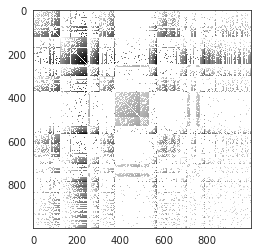

In [48]:
plt.figure(figsize=(6, 4))
plt.imshow(a, cmap='Greys', interpolation='none')

<AxesSubplot:ylabel='Count'>

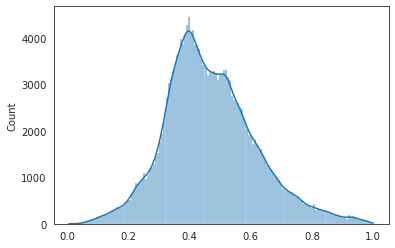

In [49]:
data = a.copy()
data = data[data>0]

sns.histplot(data, kde=True)

In [50]:
num_overlap_nodes = len(list(filter(lambda x: len(x) > 1, membership.values())))
num_overlap_nodes

0

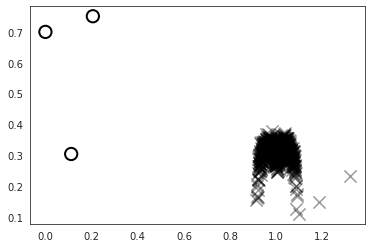

In [51]:
w, v = np.linalg.eigh(nx.normalized_laplacian_matrix(g).toarray())
ipr = 1 / np.power(v, 4).sum(0)
ipr /= len(ipr)
sort_indxs = np.argsort(w)

num_comm = len(community)
plt.scatter(
    w[sort_indxs[num_comm:]], ipr[sort_indxs[num_comm:]],
    marker='x', color='k', s=150, alpha=0.4,
)
plt.scatter(
    w[sort_indxs[:num_comm]], ipr[sort_indxs[:num_comm]],
    marker='o', edgecolors='k', lw=2, color='none', s=150,
)

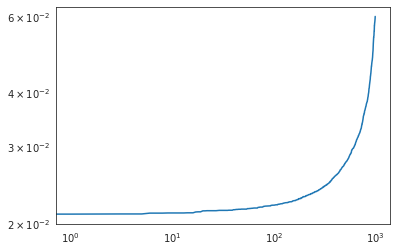

In [52]:
leading_eigenvec = v[:, sort_indxs[0]]
assert all(leading_eigenvec < 0) or all(leading_eigenvec > 0)

plt.loglog(sorted(np.abs(leading_eigenvec)))

In [53]:
partition_louvain = community_louvain.best_partition(g, resolution=1.0, random_state=RANDOM_STATE)

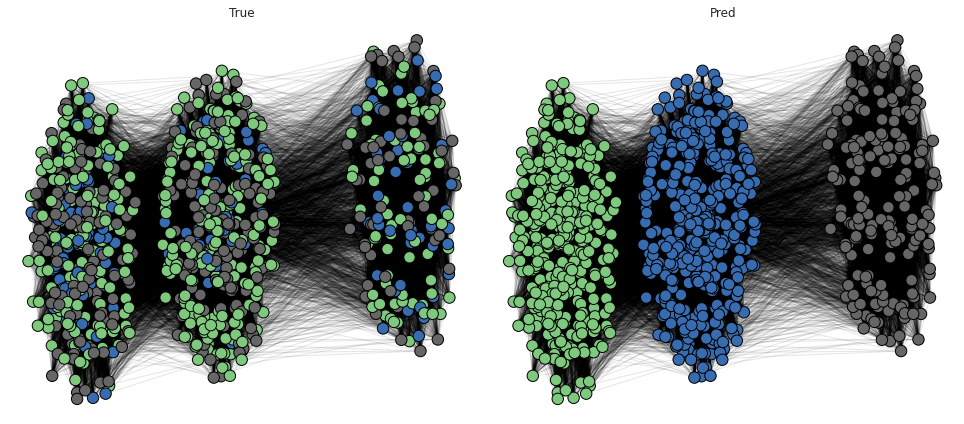

In [54]:
plot_graph(g, partition_pred=partition_louvain, partition_true=partition)

In [55]:
community_pred = convert('partition', 'community', partition=partition_louvain, random_state=rng)

In [56]:
len(community_pred)

3

In [57]:
compare_partitions(true=partition, pred=partition_louvain)

(0.003287869686605631, 0.0052141881530933945, 0.0052141881530933945)

In [59]:
match = np.zeros((3, 3))

for i in range(3):
    pred = community_pred[i]
    for j in range(3):
        true = community[j]
        match[i, j] = len(set(true).intersection(set(pred))) / len(true)   
match

array([[0.34666667, 0.41304348, 0.36612022],
       [0.47555556, 0.34782609, 0.46994536],
       [0.17777778, 0.23913043, 0.16393443]])

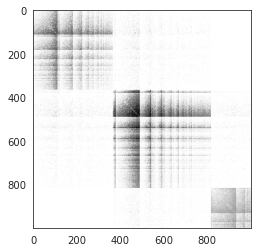

In [61]:
idxs_louvain = np.concatenate(list(community_pred.values()))
plt.imshow(a[idxs_louvain][:, idxs_louvain], cmap='Greys', interpolation='antialiased')

## GCT code

Copy and paste the following code to GCT.


```python
ds = gct.generate_random_ovp_graph_LFR('lfr_n1000_k50', 1000, k=100, maxk=200, mut=0.1, muw=0.3, beta=None, t1=None, t2=None, minc=800, maxc=None, on=200, om=5, C=None, a=0, weighted=True, seed=42, overide=True)

gt = ds.ground_truth['default']
gt.cluster.to_pickle('ground_truth.df')

g = ds.to_graph_networkx()
nx.write_gpickle(g, 'graph.nx')

```

## Load LFR

In [2]:
gct_ws = pjoin(os.environ['HOME'], 'Documents/workspaces/gct')
os.listdir(gct_ws)

['graph.nx', 'ground_truth.df']

In [3]:
gt = pd.read_pickle(pjoin(gct_ws, 'ground_truth.df'))

g = nx.read_gpickle(pjoin(gct_ws, 'graph.nx'))
a = nx.adjacency_matrix(g).toarray()
a /= np.max(a)

In [4]:
membership = {
    gt.iloc[i].node: list(int(x) - 1for x in filter(None, gt.iloc[i].cluster.split(' ')))
    for i in range(len(gt))
}

community = convert('membership', 'community', membership=membership, random_state=rng)
partition = convert('membership', 'partition', membership=membership, random_state=rng)

In [5]:
len(community)

13

In [6]:
comm_indxs = []
for x in community.values():
    y = [item for item in x if item not in comm_indxs]
    comm_indxs.extend(y)

len(comm_indxs)

1000

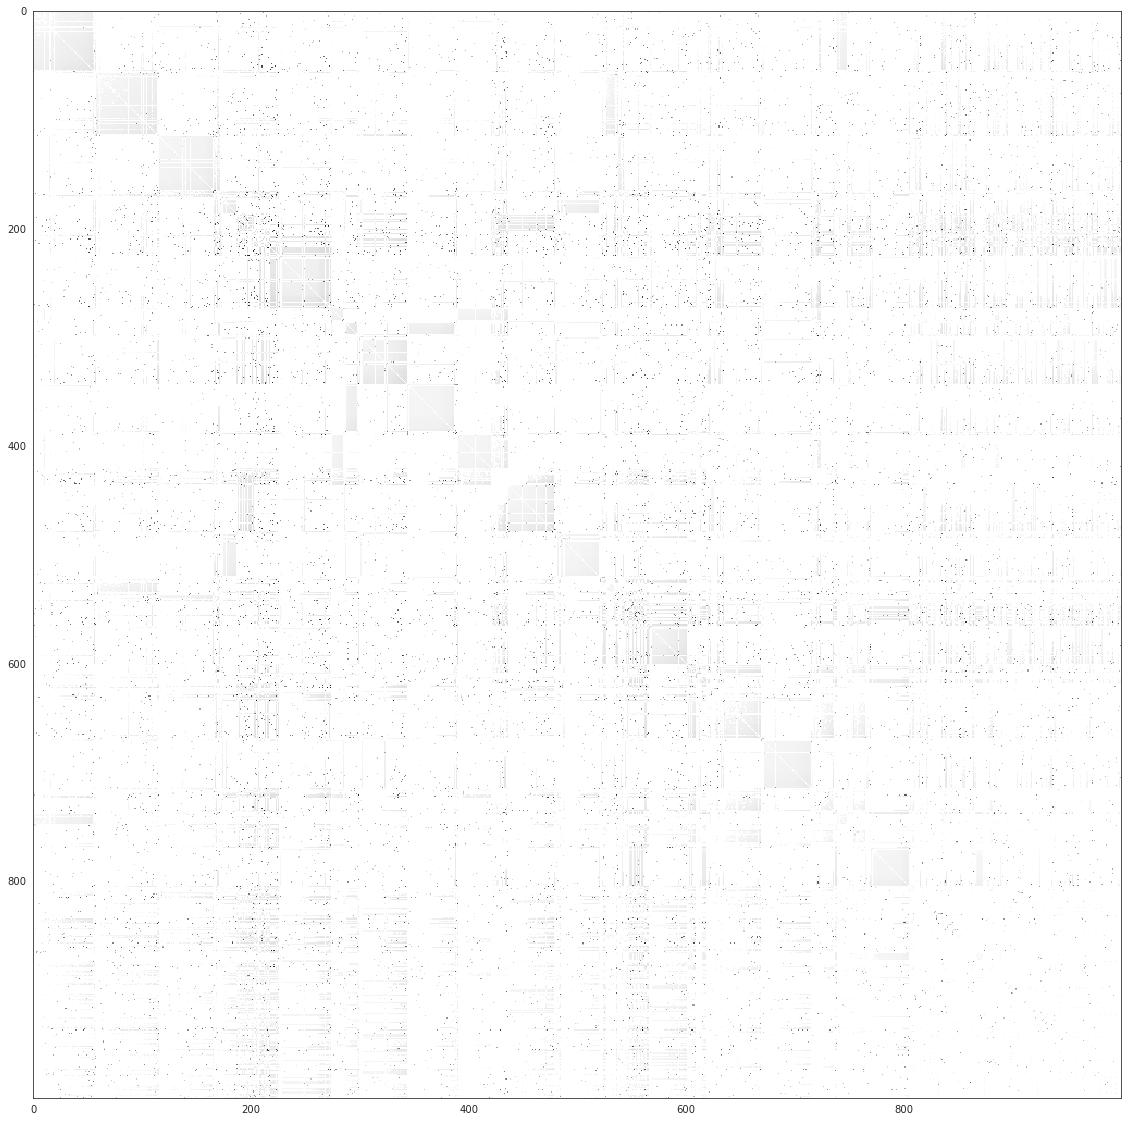

In [7]:
plt.figure(figsize=(20, 20))
plt.imshow(a, cmap='Greys', interpolation='none')

<AxesSubplot:ylabel='Count'>

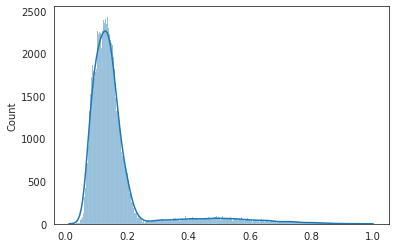

In [9]:
data = a.copy()
data = data[data>0]

sns.histplot(data, kde=True)

In [10]:
num_overlap_nodes = len(list(filter(lambda x: len(x) > 1, membership.values())))
num_overlap_nodes

200

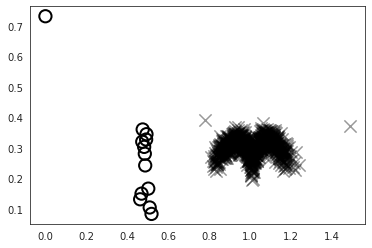

In [11]:
w, v = np.linalg.eigh(nx.normalized_laplacian_matrix(g).toarray())
ipr = 1 / np.power(v, 4).sum(0)
ipr /= len(ipr)
sort_indxs = np.argsort(w)

num_comm = len(community)
plt.scatter(
    w[sort_indxs[num_comm:]], ipr[sort_indxs[num_comm:]],
    marker='x', color='k', s=150, alpha=0.4,
)
plt.scatter(
    w[sort_indxs[:num_comm]], ipr[sort_indxs[:num_comm]],
    marker='o', edgecolors='k', lw=2, color='none', s=150,
)

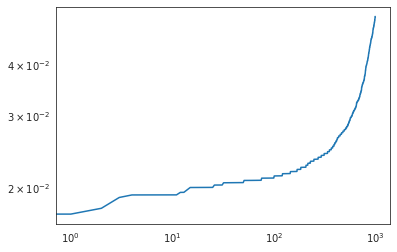

In [12]:
leading_eigenvec = v[:, sort_indxs[0]]
assert all(leading_eigenvec < 0) or all(leading_eigenvec > 0)

plt.loglog(sorted(np.abs(leading_eigenvec)))

In [13]:
partition_louvain = community_louvain.best_partition(g, resolution=1.0, random_state=RANDOM_STATE)

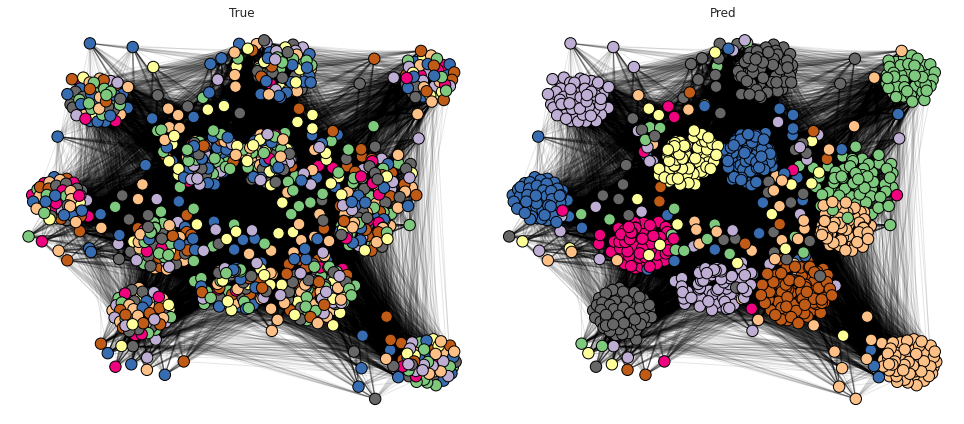

In [14]:
plot_graph(g, partition_pred=partition_louvain, partition_true=partition)

In [15]:
communities_louvain = convert('partition', 'community', partition=partition_louvain, random_state=rng)

In [16]:
len(communities_louvain)

11

In [17]:
compare_partitions(true=partition, pred=partition_louvain)

(0.004413725082748586, 0.03000610088834496, 0.03000610088834496)

## Load original LFR

In [110]:
lfr_ws = pjoin(os.environ['HOME'], 'Dropbox/git/LFR-Benchmark_UndirWeightOvp/results/t13t21.7')
os.listdir(lfr_ws)

['lfr.nmc', 'lfr.nse', 'lfr.nst']

In [111]:
g = nx.read_weighted_edgelist(pjoin(lfr_ws, 'lfr.nse'), nodetype=int)
mapping = {i: i - 1 for i in range(1, g.order() + 1)}
g = nx.relabel_nodes(g, mapping)

a = nx.adjacency_matrix(g).toarray()
a /= np.max(a)

In [112]:
with open(pjoin(lfr_ws, 'lfr.nmc'), "r") as f:
    lines = f.readlines()

membership = dict()
for line in lines:
    node, mem = line.strip('\n').split('\t')
    node = int(node) - 1
    membership[node] = list(int(x) - 1 for x in filter(None, mem.split(' ')))

community = convert('membership', 'community', membership=membership, random_state=rng)
partition = convert('membership', 'partition', membership=membership, random_state=rng)

len(community), len(membership), len(partition)

(5, 1000, 1000)

In [113]:
comm_indxs = []
for x in community.values():
    y = [item for item in x if item not in comm_indxs]
    comm_indxs.extend(y)

len(comm_indxs)

1000

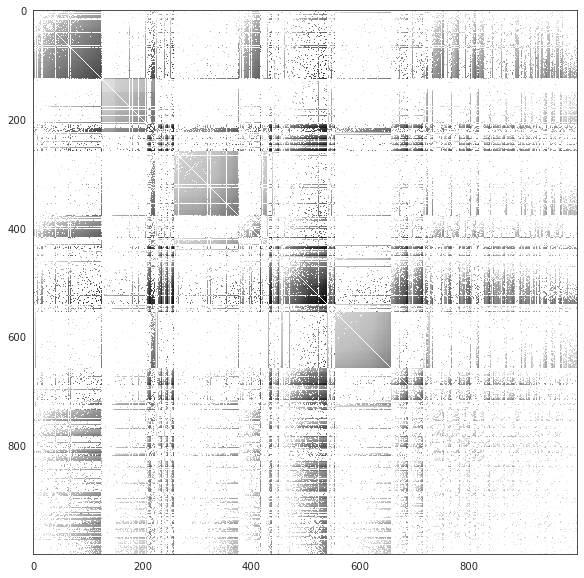

In [114]:
plt.figure(figsize=(10, 10))
plt.imshow(a, cmap='Greys', interpolation='none')

<AxesSubplot:ylabel='Count'>

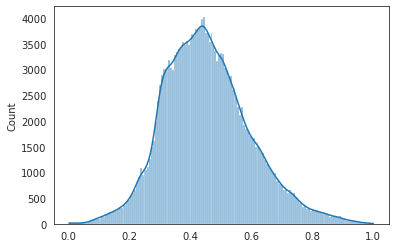

In [115]:
data = a.copy()
data = data[data>0]

sns.histplot(data, kde=True)

In [116]:
num_overlap_nodes = len(list(filter(lambda x: len(x) > 1, membership.values())))
num_overlap_nodes

100

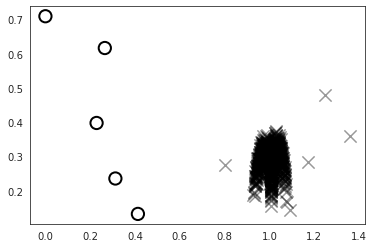

In [117]:
w, v = np.linalg.eigh(nx.normalized_laplacian_matrix(g).toarray())
ipr = 1 / np.power(v, 4).sum(0)
ipr /= len(ipr)
sort_indxs = np.argsort(w)

num_comm = len(community)
plt.scatter(
    w[sort_indxs[num_comm:]], ipr[sort_indxs[num_comm:]],
    marker='x', color='k', s=150, alpha=0.4,
)
plt.scatter(
    w[sort_indxs[:num_comm]], ipr[sort_indxs[:num_comm]],
    marker='o', edgecolors='k', lw=2, color='none', s=150,
)

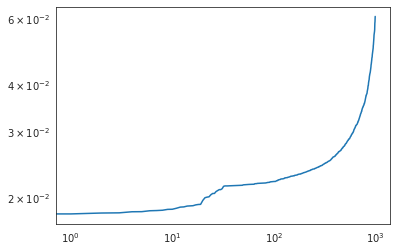

In [118]:
leading_eigenvec = v[:, sort_indxs[0]]
assert all(leading_eigenvec < 0) or all(leading_eigenvec > 0)

plt.loglog(sorted(np.abs(leading_eigenvec)))

In [119]:
partition_louvain = community_louvain.best_partition(g, resolution=1.0, random_state=RANDOM_STATE)

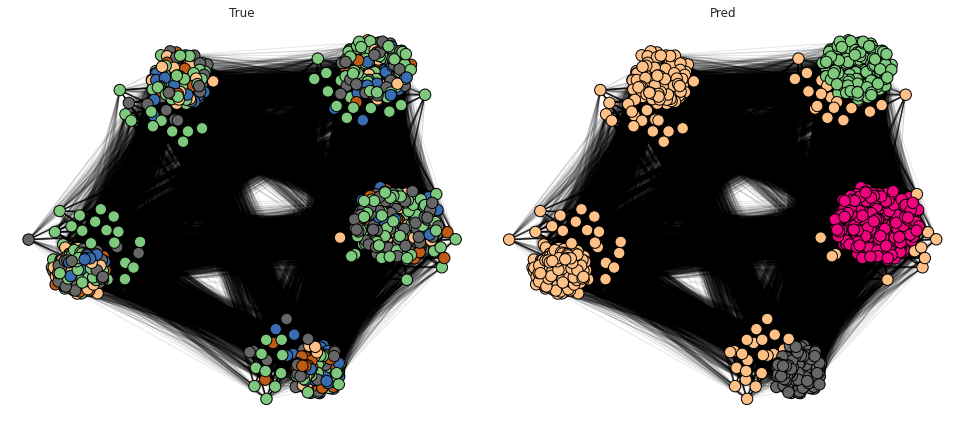

In [120]:
plot_graph(g, partition_pred=partition_louvain, partition_true=partition)

In [140]:
community_pred = convert('partition', 'community', partition=partition_louvain, random_state=rng)

In [141]:
len(community_pred)

4

In [142]:
compare_partitions(true=partition, pred=partition_louvain)

(0.007177942678098936, 0.011436703096110884, 0.011436703096110884)

In [143]:
dict(sorted(partition_louvain.items()))

{0: 0,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 3,
 6: 0,
 7: 3,
 8: 3,
 9: 2,
 10: 3,
 11: 3,
 12: 1,
 13: 2,
 14: 2,
 15: 1,
 16: 1,
 17: 3,
 18: 0,
 19: 2,
 20: 0,
 21: 1,
 22: 2,
 23: 3,
 24: 0,
 25: 1,
 26: 1,
 27: 0,
 28: 2,
 29: 1,
 30: 2,
 31: 2,
 32: 2,
 33: 2,
 34: 3,
 35: 1,
 36: 2,
 37: 2,
 38: 1,
 39: 0,
 40: 3,
 41: 1,
 42: 2,
 43: 1,
 44: 2,
 45: 1,
 46: 2,
 47: 2,
 48: 3,
 49: 3,
 50: 2,
 51: 2,
 52: 3,
 53: 2,
 54: 0,
 55: 2,
 56: 2,
 57: 1,
 58: 1,
 59: 2,
 60: 2,
 61: 1,
 62: 0,
 63: 0,
 64: 0,
 65: 2,
 66: 1,
 67: 1,
 68: 2,
 69: 2,
 70: 1,
 71: 2,
 72: 3,
 73: 3,
 74: 2,
 75: 2,
 76: 3,
 77: 0,
 78: 3,
 79: 1,
 80: 0,
 81: 2,
 82: 1,
 83: 1,
 84: 2,
 85: 1,
 86: 1,
 87: 2,
 88: 1,
 89: 1,
 90: 1,
 91: 2,
 92: 0,
 93: 1,
 94: 2,
 95: 3,
 96: 3,
 97: 1,
 98: 1,
 99: 3,
 100: 1,
 101: 2,
 102: 2,
 103: 2,
 104: 3,
 105: 2,
 106: 2,
 107: 1,
 108: 1,
 109: 1,
 110: 2,
 111: 1,
 112: 1,
 113: 2,
 114: 1,
 115: 1,
 116: 1,
 117: 1,
 118: 0,
 119: 3,
 120: 2,
 121: 0,
 122: 1,
 12

In [144]:
partition

{0: 4,
 1: 3,
 2: 3,
 3: 3,
 4: 3,
 5: 2,
 6: 4,
 7: 2,
 8: 2,
 9: 0,
 10: 2,
 11: 2,
 12: 1,
 13: 0,
 14: 0,
 15: 0,
 16: 1,
 17: 2,
 18: 4,
 19: 0,
 20: 4,
 21: 3,
 22: 0,
 23: 2,
 24: 4,
 25: 2,
 26: 3,
 27: 4,
 28: 0,
 29: 1,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 2,
 35: 3,
 36: 0,
 37: 0,
 38: 3,
 39: 4,
 40: 2,
 41: 1,
 42: 0,
 43: 1,
 44: 0,
 45: 1,
 46: 0,
 47: 0,
 48: 2,
 49: 2,
 50: 0,
 51: 0,
 52: 2,
 53: 0,
 54: 4,
 55: 0,
 56: 0,
 57: 3,
 58: 1,
 59: 0,
 60: 0,
 61: 0,
 62: 4,
 63: 4,
 64: 4,
 65: 0,
 66: 1,
 67: 1,
 68: 0,
 69: 0,
 70: 1,
 71: 0,
 72: 2,
 73: 2,
 74: 0,
 75: 0,
 76: 2,
 77: 4,
 78: 2,
 79: 3,
 80: 4,
 81: 0,
 82: 1,
 83: 3,
 84: 0,
 85: 2,
 86: 1,
 87: 0,
 88: 1,
 89: 1,
 90: 1,
 91: 0,
 92: 4,
 93: 1,
 94: 0,
 95: 2,
 96: 2,
 97: 3,
 98: 1,
 99: 2,
 100: 4,
 101: 0,
 102: 0,
 103: 0,
 104: 2,
 105: 0,
 106: 0,
 107: 3,
 108: 3,
 109: 1,
 110: 0,
 111: 3,
 112: 1,
 113: 0,
 114: 1,
 115: 1,
 116: 1,
 117: 4,
 118: 4,
 119: 2,
 120: 0,
 121: 4,
 122: 3,
 12

In [146]:
len(community), len(community_pred)

(5, 4)

In [155]:
match = np.zeros((4, 5))

for i in range(4):
    pred = community_pred[i]
    for j in range(5):
        true = community[j]
        match[i, j] = len(set(true).intersection(set(pred))) / len(true)
        
match

array([[0.24721604, 0.22897196, 0.23076923, 0.21666667, 0.19642857],
       [0.31848552, 0.30373832, 0.29411765, 0.28888889, 0.26488095],
       [0.34298441, 0.35981308, 0.3438914 , 0.32777778, 0.4375    ],
       [0.09131403, 0.10747664, 0.13122172, 0.16666667, 0.10119048]])

In [149]:
community[0]

[9,
 13,
 14,
 15,
 19,
 22,
 25,
 28,
 30,
 31,
 32,
 33,
 36,
 37,
 42,
 44,
 46,
 47,
 50,
 51,
 53,
 55,
 56,
 59,
 60,
 61,
 65,
 68,
 69,
 70,
 71,
 74,
 75,
 81,
 84,
 85,
 86,
 87,
 91,
 94,
 100,
 101,
 102,
 103,
 105,
 106,
 110,
 113,
 116,
 117,
 120,
 123,
 124,
 126,
 133,
 136,
 142,
 143,
 144,
 147,
 149,
 151,
 153,
 154,
 157,
 158,
 160,
 163,
 165,
 166,
 167,
 172,
 173,
 174,
 179,
 180,
 183,
 184,
 186,
 187,
 192,
 194,
 199,
 200,
 201,
 205,
 209,
 213,
 214,
 219,
 224,
 231,
 232,
 234,
 236,
 237,
 240,
 246,
 247,
 248,
 252,
 253,
 258,
 262,
 264,
 271,
 273,
 274,
 279,
 280,
 281,
 282,
 284,
 290,
 292,
 293,
 294,
 295,
 301,
 309,
 311,
 312,
 320,
 322,
 323,
 324,
 326,
 328,
 330,
 331,
 334,
 335,
 339,
 340,
 343,
 344,
 351,
 353,
 354,
 362,
 363,
 368,
 374,
 381,
 382,
 386,
 389,
 390,
 391,
 392,
 395,
 396,
 402,
 404,
 411,
 412,
 415,
 417,
 418,
 419,
 420,
 421,
 425,
 426,
 430,
 438,
 442,
 444,
 448,
 450,
 451,
 454,
 455,
 45

In [151]:
community_pred[1]

[4,
 5,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 178,
 179,
 180,
 181,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 207,
 208,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 228,
 251,
 377,
 406,
 432,
 435,
 443,
 450,
 456,
 458,
 471,
 507,
 524,
 541,
 543,
 548,
 549,
 553,
 555,
 556,
 557,
 558,
 559,
 560,
 561,
 562,
 563,
 564,
 565,
 566,
 567,
 568,
 569,
 570,
 571,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579,
 580,
 581,
 582,
 583,
 584,
 585,
 586,
 587,
 588,
 589,
 590,
 591,
 592,
 593,
 594,
 595,
 596,
 598,
 600,
 601,
 602,
 603,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 6

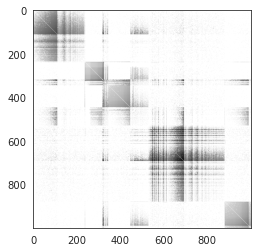

In [134]:
idxs_louvain = np.concatenate(list(communities_louvain.values()))
plt.imshow(a[idxs_louvain][:, idxs_louvain], cmap='Greys', interpolation='antialiased')

## LFR no overlap

In [66]:
lfr_ws = pjoin(os.environ['HOME'], 'Dropbox/git/LFR-Benchmark_UndirWeightOvp/results/no_overlap')
os.listdir(lfr_ws)

['lfr.nmc', 'lfr.nse', 'lfr.nst']

In [67]:
g = nx.read_weighted_edgelist(pjoin(lfr_ws, 'lfr.nse'), nodetype=int)
g = nx.relabel_nodes(
    G=g,
    mapping={i: i - 1 for i in range(1, g.order() + 1)},
    copy=True,
)

a = nx.adjacency_matrix(g).toarray()
a /= np.max(a)

In [76]:
for x in g.edges(data=True):
    i, j, d = x
    if i == 0 and j == 500:
        print(i,j, d)

0 500 {'weight': 10.2312}


In [77]:
with open(pjoin(lfr_ws, 'lfr.nmc'), "r") as f:
    lines = f.readlines()

membership = dict()
for line in lines:
    node, mem = line.strip('\n').split('\t')
    node = int(node) - 1
    membership[node] = list(int(x) - 1 for x in filter(None, mem.split(' ')))

community = convert('membership', 'community', membership=membership, random_state=rng)
partition = convert('membership', 'partition', membership=membership, random_state=rng)

len(community), len(membership), len(partition)

(3, 1000, 1000)

In [78]:
membership

{0: [1],
 1: [0],
 2: [2],
 3: [1],
 4: [0],
 5: [2],
 6: [2],
 7: [1],
 8: [0],
 9: [0],
 10: [1],
 11: [0],
 12: [0],
 13: [2],
 14: [0],
 15: [1],
 16: [0],
 17: [0],
 18: [2],
 19: [2],
 20: [2],
 21: [2],
 22: [0],
 23: [2],
 24: [0],
 25: [2],
 26: [2],
 27: [0],
 28: [2],
 29: [1],
 30: [2],
 31: [0],
 32: [2],
 33: [0],
 34: [0],
 35: [0],
 36: [0],
 37: [0],
 38: [0],
 39: [2],
 40: [2],
 41: [2],
 42: [0],
 43: [1],
 44: [1],
 45: [1],
 46: [2],
 47: [1],
 48: [0],
 49: [2],
 50: [2],
 51: [0],
 52: [2],
 53: [0],
 54: [0],
 55: [0],
 56: [1],
 57: [0],
 58: [1],
 59: [0],
 60: [1],
 61: [1],
 62: [1],
 63: [1],
 64: [2],
 65: [2],
 66: [0],
 67: [0],
 68: [2],
 69: [0],
 70: [0],
 71: [0],
 72: [1],
 73: [0],
 74: [1],
 75: [1],
 76: [0],
 77: [0],
 78: [0],
 79: [0],
 80: [1],
 81: [0],
 82: [2],
 83: [2],
 84: [0],
 85: [0],
 86: [1],
 87: [2],
 88: [1],
 89: [0],
 90: [1],
 91: [2],
 92: [2],
 93: [0],
 94: [1],
 95: [2],
 96: [0],
 97: [0],
 98: [2],
 99: [0],
 100: [1],

In [33]:
partition

{0: 1,
 1: 0,
 2: 2,
 3: 1,
 4: 0,
 5: 2,
 6: 2,
 7: 1,
 8: 0,
 9: 0,
 10: 1,
 11: 0,
 12: 0,
 13: 2,
 14: 0,
 15: 1,
 16: 0,
 17: 0,
 18: 2,
 19: 2,
 20: 2,
 21: 2,
 22: 0,
 23: 2,
 24: 0,
 25: 2,
 26: 2,
 27: 0,
 28: 2,
 29: 1,
 30: 2,
 31: 0,
 32: 2,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 2,
 40: 2,
 41: 2,
 42: 0,
 43: 1,
 44: 1,
 45: 1,
 46: 2,
 47: 1,
 48: 0,
 49: 2,
 50: 2,
 51: 0,
 52: 2,
 53: 0,
 54: 0,
 55: 0,
 56: 1,
 57: 0,
 58: 1,
 59: 0,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 2,
 65: 2,
 66: 0,
 67: 0,
 68: 2,
 69: 0,
 70: 0,
 71: 0,
 72: 1,
 73: 0,
 74: 1,
 75: 1,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 1,
 81: 0,
 82: 2,
 83: 2,
 84: 0,
 85: 0,
 86: 1,
 87: 2,
 88: 1,
 89: 0,
 90: 1,
 91: 2,
 92: 2,
 93: 0,
 94: 1,
 95: 2,
 96: 0,
 97: 0,
 98: 2,
 99: 0,
 100: 1,
 101: 2,
 102: 0,
 103: 0,
 104: 0,
 105: 2,
 106: 2,
 107: 0,
 108: 2,
 109: 1,
 110: 0,
 111: 2,
 112: 1,
 113: 1,
 114: 0,
 115: 2,
 116: 2,
 117: 2,
 118: 2,
 119: 1,
 120: 0,
 121: 1,
 122: 0,
 12

In [34]:
comm_indxs = []
for x in community.values():
    y = [item for item in x if item not in comm_indxs]
    comm_indxs.extend(y)

len(comm_indxs)

1000

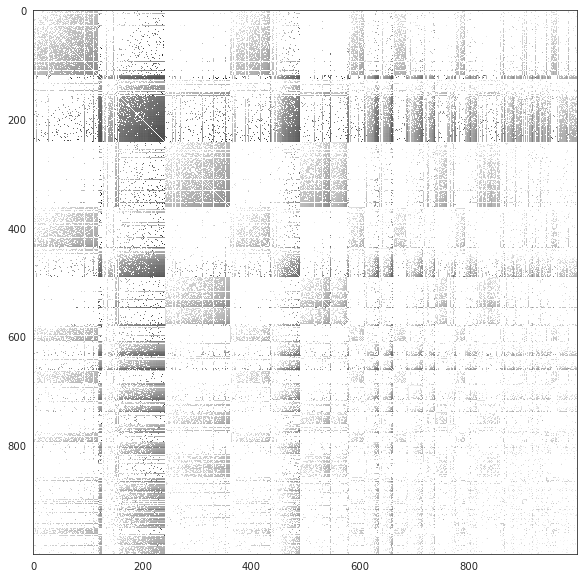

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(a, cmap='Greys', interpolation='none')

<AxesSubplot:ylabel='Count'>

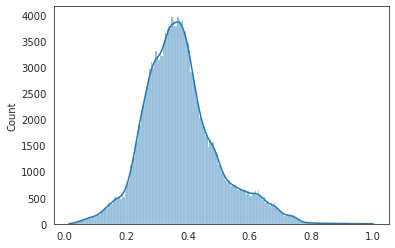

In [7]:
data = a.copy()
data = data[data>0]

sns.histplot(data, kde=True)

In [8]:
num_overlap_nodes = len(list(filter(lambda x: len(x) > 1, membership.values())))
num_overlap_nodes

0

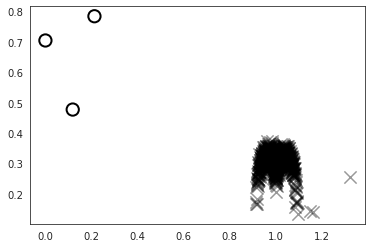

In [9]:
w, v = np.linalg.eigh(nx.normalized_laplacian_matrix(g).toarray())
ipr = 1 / np.power(v, 4).sum(0)
ipr /= len(ipr)
sort_indxs = np.argsort(w)

num_comm = len(community)
plt.scatter(
    w[sort_indxs[num_comm:]], ipr[sort_indxs[num_comm:]],
    marker='x', color='k', s=150, alpha=0.4,
)
plt.scatter(
    w[sort_indxs[:num_comm]], ipr[sort_indxs[:num_comm]],
    marker='o', edgecolors='k', lw=2, color='none', s=150,
)

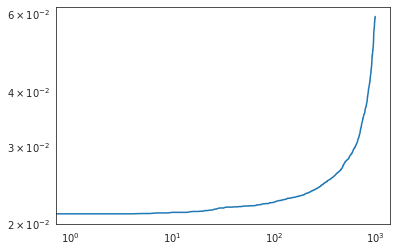

In [10]:
leading_eigenvec = v[:, sort_indxs[0]]
assert all(leading_eigenvec < 0) or all(leading_eigenvec > 0)

plt.loglog(sorted(np.abs(leading_eigenvec)))

In [11]:
partition_louvain = community_louvain.best_partition(g, resolution=1.0, random_state=RANDOM_STATE)

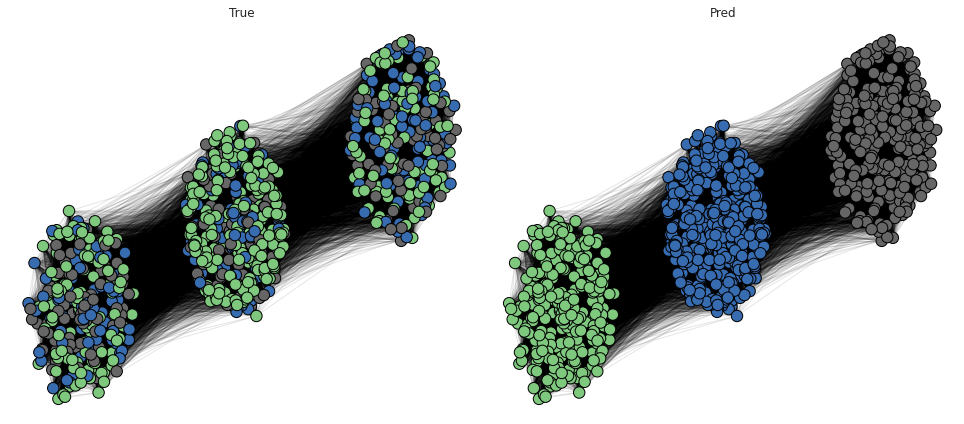

In [12]:
plot_graph(g, partition_pred=partition_louvain, partition_true=partition)

In [81]:
community_pred = convert('partition', 'community', partition=partition_louvain, random_state=rng)

In [82]:
len(community_pred)

3

In [83]:
compare_partitions(true=partition, pred=partition_louvain)

(0.006057076808711531, 0.00792169439108566, 0.00792169439108566)

In [84]:
community_pred

{0: [0,
  1,
  2,
  4,
  5,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  135,
  147,
  362,
  363,
  364,
  367,
  368,
  369,
  371,
  373,
  374,
  375,
  376,
  377,
  378,
  379,
  380,
  381,
  382,
  383,
  384,
  385,
  386,
  387,
  388,
  389,
  391,
  392,
  393,
  394,
  395,
  397,
  398,
  399,
  400,
  401,
  402,
  403,
  404,
  405,
  406,
  407,
  408,
  409,

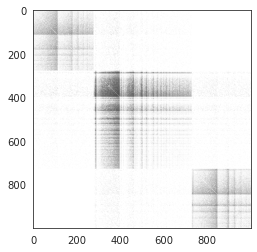

In [183]:
idxs_louvain = np.concatenate(list(community_pred.values()))
plt.imshow(a[idxs_louvain][:, idxs_louvain], cmap='Greys', interpolation='antialiased')

## LFR no overlap 2

In [86]:
lfr_ws = pjoin(os.environ['HOME'], 'Dropbox/git/LFR-Benchmark_UndirWeightOvp/results/no_overlap2')
os.listdir(lfr_ws)

['lfr.cnl', 'lfr.nse', 'lfr.nst']

In [87]:
g = nx.read_weighted_edgelist(pjoin(lfr_ws, 'lfr.nse'), nodetype=int)
g = nx.relabel_nodes(
    G=g,
    mapping={i: i - 1 for i in range(1, g.order() + 1)},
    copy=True,
)

a = nx.adjacency_matrix(g).toarray()
a /= np.max(a)

In [95]:
with open(pjoin(lfr_ws, 'lfr.cnl'), "r") as f:
    lines = f.readlines()
    
community = {
    i: list(int(x) - 1 for x in (filter(None, line.strip('\n').split(' '))))
    for i, line in enumerate(lines)
}
membership = convert('community', 'membership', community=community, random_state=rng)
partition = convert('community', 'partition', community=community, random_state=rng)

len(community), len(membership), len(partition)

(3, 1000, 1000)

In [96]:
comm_indxs = []
for x in community.values():
    y = [item for item in x if item not in comm_indxs]
    comm_indxs.extend(y)

len(comm_indxs)

1000

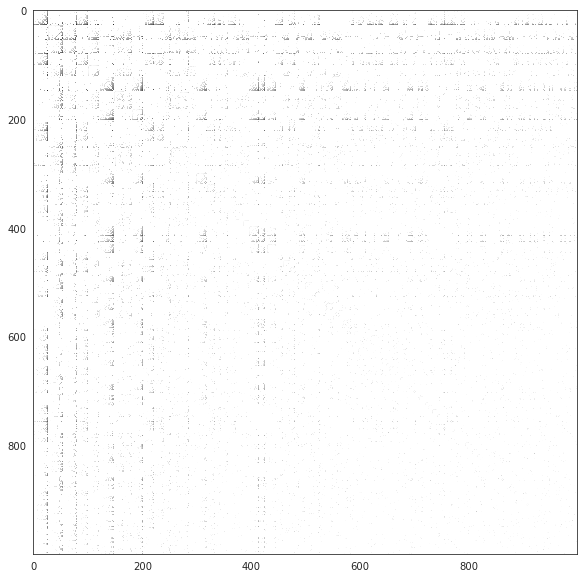

In [97]:
plt.figure(figsize=(10, 10))
plt.imshow(a, cmap='Greys', interpolation='none')

<AxesSubplot:ylabel='Count'>

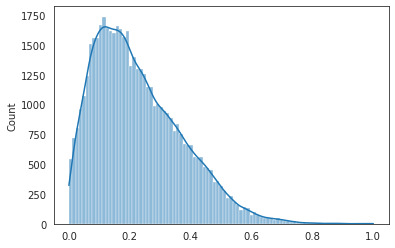

In [98]:
data = a.copy()
data = data[data>0]

sns.histplot(data, kde=True)

In [99]:
num_overlap_nodes = len(list(filter(lambda x: len(x) > 1, membership.values())))
num_overlap_nodes

0

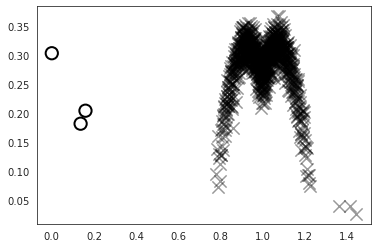

In [100]:
w, v = np.linalg.eigh(nx.normalized_laplacian_matrix(g).toarray())
ipr = 1 / np.power(v, 4).sum(0)
ipr /= len(ipr)
sort_indxs = np.argsort(w)

num_comm = len(community)
plt.scatter(
    w[sort_indxs[num_comm:]], ipr[sort_indxs[num_comm:]],
    marker='x', color='k', s=150, alpha=0.4,
)
plt.scatter(
    w[sort_indxs[:num_comm]], ipr[sort_indxs[:num_comm]],
    marker='o', edgecolors='k', lw=2, color='none', s=150,
)

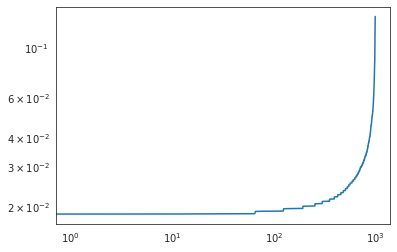

In [101]:
leading_eigenvec = v[:, sort_indxs[0]]
assert all(leading_eigenvec < 0) or all(leading_eigenvec > 0)

plt.loglog(sorted(np.abs(leading_eigenvec)))

In [102]:
partition_louvain = community_louvain.best_partition(g, resolution=1.0, random_state=RANDOM_STATE)

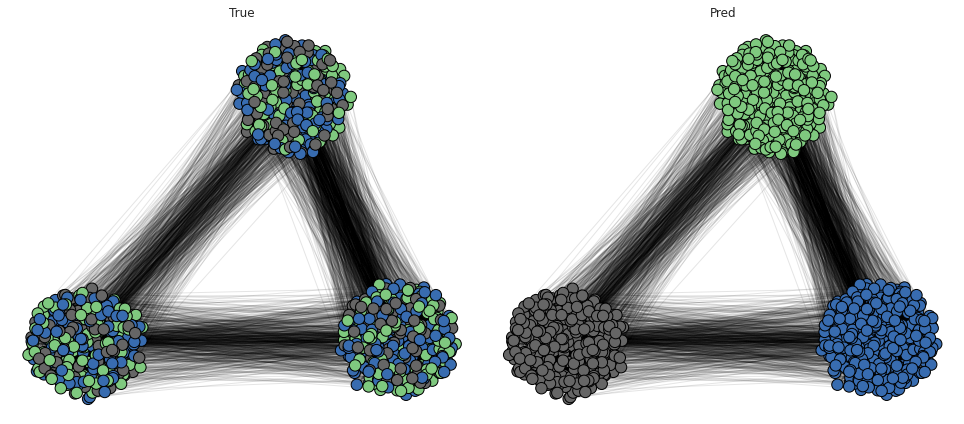

In [103]:
plot_graph(g, partition_pred=partition_louvain, partition_true=partition)

In [104]:
community_pred = convert('partition', 'community', partition=partition_louvain, random_state=rng)

In [105]:
len(community_pred)

3

In [106]:
compare_partitions(true=partition, pred=partition_louvain)

(-0.0009017189869345896, 0.0009375824340007519, 0.0009375824340007519)

In [107]:
community_pred

{0: [0,
  1,
  2,
  3,
  4,
  6,
  7,
  8,
  10,
  11,
  12,
  13,
  14,
  15,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  31,
  32,
  79,
  80,
  81,
  82,
  83,
  85,
  87,
  88,
  89,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  104,
  105,
  169,
  183,
  202,
  203,
  205,
  206,
  207,
  208,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221,
  222,
  223,
  224,
  225,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  238,
  239,
  255,
  268,
  285,
  288,
  290,
  304,
  320,
  321,
  322,
  324,
  325,
  326,
  329,
  330,
  331,
  332,
  333,
  334,
  335,
  336,
  338,
  340,
  341,
  342,
  343,
  344,
  350,
  352,
  358,
  359,
  360,
  361,
  362,
  363,
  364,
  366,
  367,
  368,
  369,
  370,
  371,
  372,
  379,
  446,
  447,
  448,
  449,
  450,
  451,
  452,
  453,
  454,
  455,
  456,
  457,
  458,
  459,
  471,
  473,
  474,
  475,
  476,
  477,


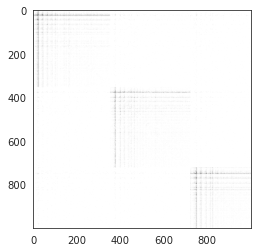

In [108]:
idxs_louvain = np.concatenate(list(community_pred.values()))
plt.imshow(a[idxs_louvain][:, idxs_louvain], cmap='Greys', interpolation='antialiased')

In [109]:
community_pred

{0: [0,
  1,
  2,
  3,
  4,
  6,
  7,
  8,
  10,
  11,
  12,
  13,
  14,
  15,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  31,
  32,
  79,
  80,
  81,
  82,
  83,
  85,
  87,
  88,
  89,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  104,
  105,
  169,
  183,
  202,
  203,
  205,
  206,
  207,
  208,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221,
  222,
  223,
  224,
  225,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  238,
  239,
  255,
  268,
  285,
  288,
  290,
  304,
  320,
  321,
  322,
  324,
  325,
  326,
  329,
  330,
  331,
  332,
  333,
  334,
  335,
  336,
  338,
  340,
  341,
  342,
  343,
  344,
  350,
  352,
  358,
  359,
  360,
  361,
  362,
  363,
  364,
  366,
  367,
  368,
  369,
  370,
  371,
  372,
  379,
  446,
  447,
  448,
  449,
  450,
  451,
  452,
  453,
  454,
  455,
  456,
  457,
  458,
  459,
  471,
  473,
  474,
  475,
  476,
  477,


In [110]:
community

{0: [0,
  3,
  9,
  10,
  16,
  17,
  19,
  26,
  28,
  32,
  33,
  40,
  42,
  44,
  45,
  46,
  49,
  50,
  53,
  54,
  56,
  62,
  63,
  65,
  66,
  67,
  68,
  69,
  70,
  75,
  76,
  77,
  89,
  90,
  94,
  95,
  107,
  109,
  116,
  117,
  119,
  123,
  128,
  131,
  132,
  133,
  137,
  138,
  143,
  144,
  146,
  150,
  151,
  153,
  155,
  156,
  161,
  167,
  170,
  171,
  174,
  175,
  176,
  177,
  183,
  184,
  186,
  187,
  188,
  190,
  191,
  194,
  196,
  197,
  200,
  210,
  211,
  212,
  215,
  216,
  219,
  221,
  223,
  226,
  228,
  232,
  234,
  237,
  239,
  240,
  242,
  243,
  244,
  246,
  250,
  251,
  252,
  255,
  257,
  258,
  259,
  261,
  263,
  266,
  270,
  272,
  276,
  279,
  281,
  294,
  295,
  297,
  300,
  302,
  306,
  309,
  311,
  312,
  314,
  316,
  318,
  324,
  328,
  332,
  339,
  344,
  348,
  349,
  350,
  359,
  361,
  362,
  363,
  364,
  365,
  367,
  375,
  382,
  386,
  387,
  389,
  391,
  393,
  394,
  402,
  403,
  404,
  405,


## Load Ca data

In [2]:
keywords = ['ca', 'ses-1', 'sub-SLC06', 'rest']
run_duration = 600   # 600 seconds
ca_fs = 10
exclude = 60

ca = load_ca_data(
    config=ProcessConfig(),
    keywords=keywords,
    ca_fs=ca_fs,
    run_duration=run_duration,
    exclude=exclude,
    verbose=True,
) 

Data from 4 runs loaded:

['sub-SLC06_ses-1_run-1_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-3_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-5_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-7_task-rest_ca.npy']

-->  60 s  <-- excluded from the beginning of each run. Combined runs duration:

00 - 00:36:00  (dd - hh:mm:ss)



In [3]:
ca.shape

(190, 186, 21600)

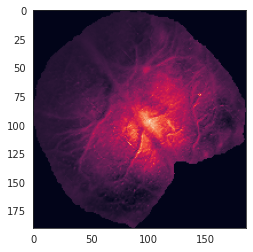

In [8]:
data = ca.copy()
data -= np.min(data)

plt.imshow(data.mean(-1))